In [1]:
import pandas as pd
import plotnine as p9
import numpy as np


In [2]:
# read data
results_df = pd.read_csv("Simulations/results/simulation_results_CAR_model.csv")


In [3]:
# define relative error
rel_error = np.abs(
    results_df['bias'] / results_df['true']
)
results_df["rmse_point"] = rel_error


In [5]:
# save summary stat across iterations

# Define model order and rename categories
model_rename = {
    "true_net": "True",
    "MWG": "BG",
    "MWG_rep": "BG (rep)",
    "obs_net": "Obs.",
}

results_df["model"] = results_df["model"].replace(model_rename)
results_df["model"] = pd.Categorical(results_df["model"], categories=model_rename.values(), ordered=True)



summary_df = (
    results_df
    .groupby(["gamma_noise", "model", "estimand"])
    .agg(

        mean = ("mean", "mean"),
        median = ("median", "median"),
        std = ("std", "mean"),
        true = ("true", "mean"),
        true_std = ("true", "std"),

        coverage = ("covering", "mean"),

        rmse_point = ("rmse_point", "mean"),
        rmse_point_q5 = ("rmse_point", lambda x: np.percentile(x, 2.5)),
        rmse_point_q95 = ("rmse_point", lambda x: np.percentile(x, 97.5)),
        )
    .reset_index()
)

summary_df = summary_df[summary_df["estimand"] != "estimand"]


C:\Users\bar21\AppData\Local\Temp\ipykernel_3404\945453451.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


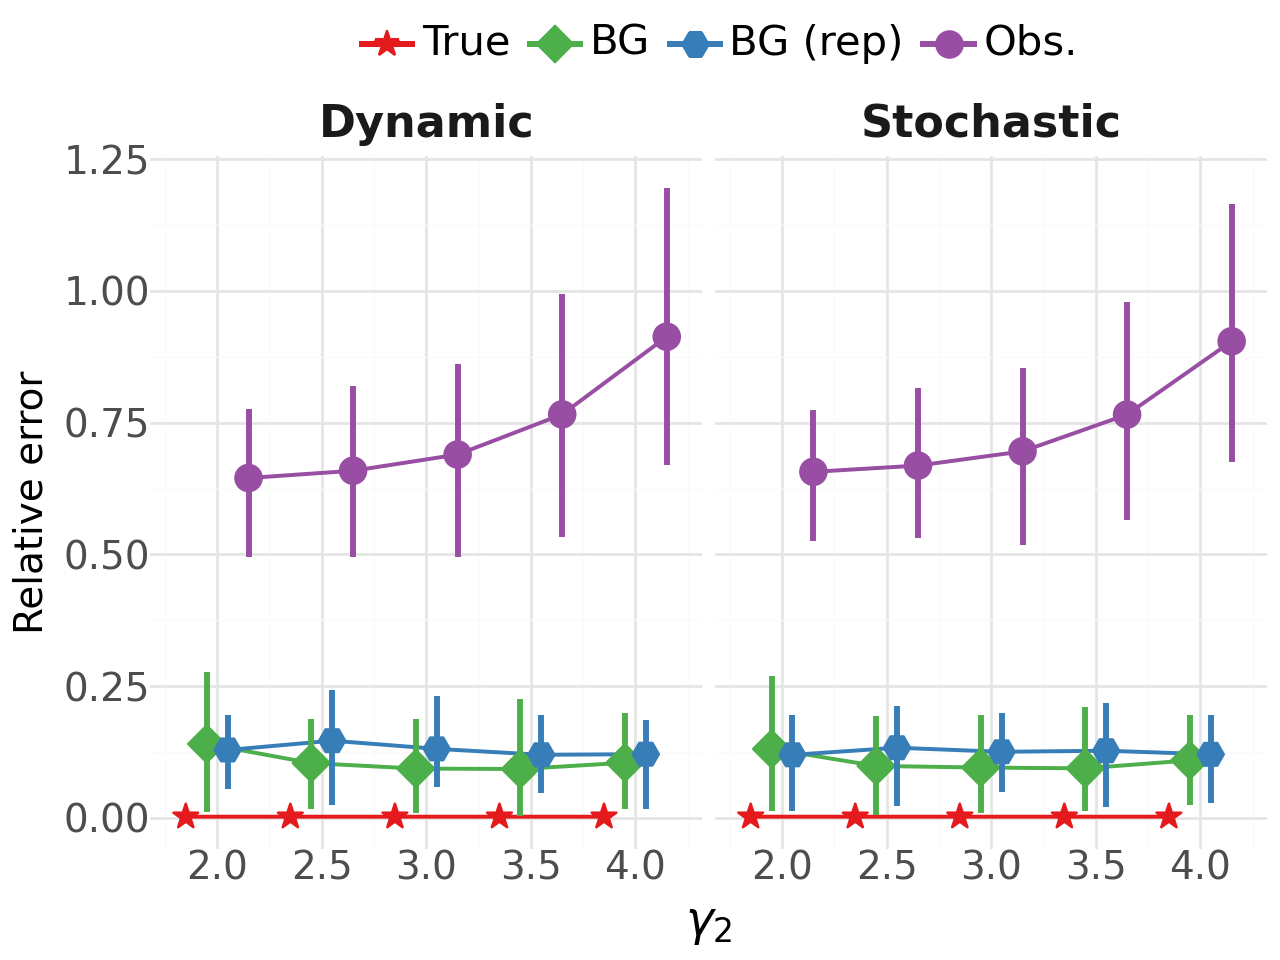

c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: Simulations/results/figs/plot_rel_error.png


In [6]:

# Rename facet titles
facet_labels = {"dynamic": "Dynamic", "stoch": "Stochastic"}
summary_df["estimand"] = summary_df["estimand"].replace(facet_labels)


custom_palette = {
    "True": "#E41A1C",   # Red
    "BG": "#4DAF4A",        # Green
    "BG (rep)": "#377EB8",    # Blue
    "Obs.": "#984EA3"     # Purple
    # "MWG": "#4DAF4A",        # Green
    # "MWG_rep": "#377EB8",    # Blue
    # "Obs": "#984EA3"     # Purple
}

custom_shapes = {
    "True": '*',      # star
    "BG": 'D',        # diamond
    "BG (rep)": 'H',  # hexagon
    "Obs.": 'o'       # circle
}

plot = (
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="rmse_point", 
                                 group="model", 
                                 color="model",
                                 shape="model"
                                 ))
    + p9.geom_line(position=p9.position_dodge(width=0.4), size=.8)  
    + p9.geom_pointrange(
        p9.aes(ymin="rmse_point_q5", ymax="rmse_point_q95"),
        position=p9.position_dodge(width=0.4),
        size=1.2,
    )
    + p9.theme_minimal()
    + p9.facet_wrap("estimand", scales="fixed")

    + p9.labs(y="Relative error", x=r'$\gamma_2$', color="", shape="")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_color_manual(values=custom_palette)
    + p9.scale_shape_manual(values=custom_shapes)

    + p9.theme(
        legend_text=p9.element_text(size=15),
        legend_key_size=20,
        axis_title_x=p9.element_text(size=17,),
        axis_title_y=p9.element_text(size=14,),
        axis_text_x=p9.element_text(size=14),
        axis_text_y=p9.element_text(size=14),
        strip_text=p9.element_text(size=16, weight='bold'),  
        legend_position="top",
    )
)

plot.show()

plot.save("Simulations/results/figs/plot_rel_error.png", dpi=300)

The plot shows the mean (95% percentiles) of relative error for each estimand (dynamic and stochastic) across 'gamma' values. As we move right in the x-axis, the level of noise increases and proxy networks becomes weaker. 

Let $\hat{\tau} = \frac{1}{NM}\sum_m\sum_i \hat{\tau}_{i,m} $ be the point estimate across units $i=1,\ldots,N$ and posterior sample $m=1,\ldots,M$. In our case $M=10^4$.
The relative error is defined as 
$$
RE = \frac{\lvert \hat{\tau} -\tau \rvert}{\lvert \tau \rvert}
$$
\
RE therefore accounts for precision of estimates.
\
The plot show the mean (95% symmetric interval) across $300$ iterations (so total $300 \times 5$ iterations including different $\gamma$ values) and for $N=500$ units.

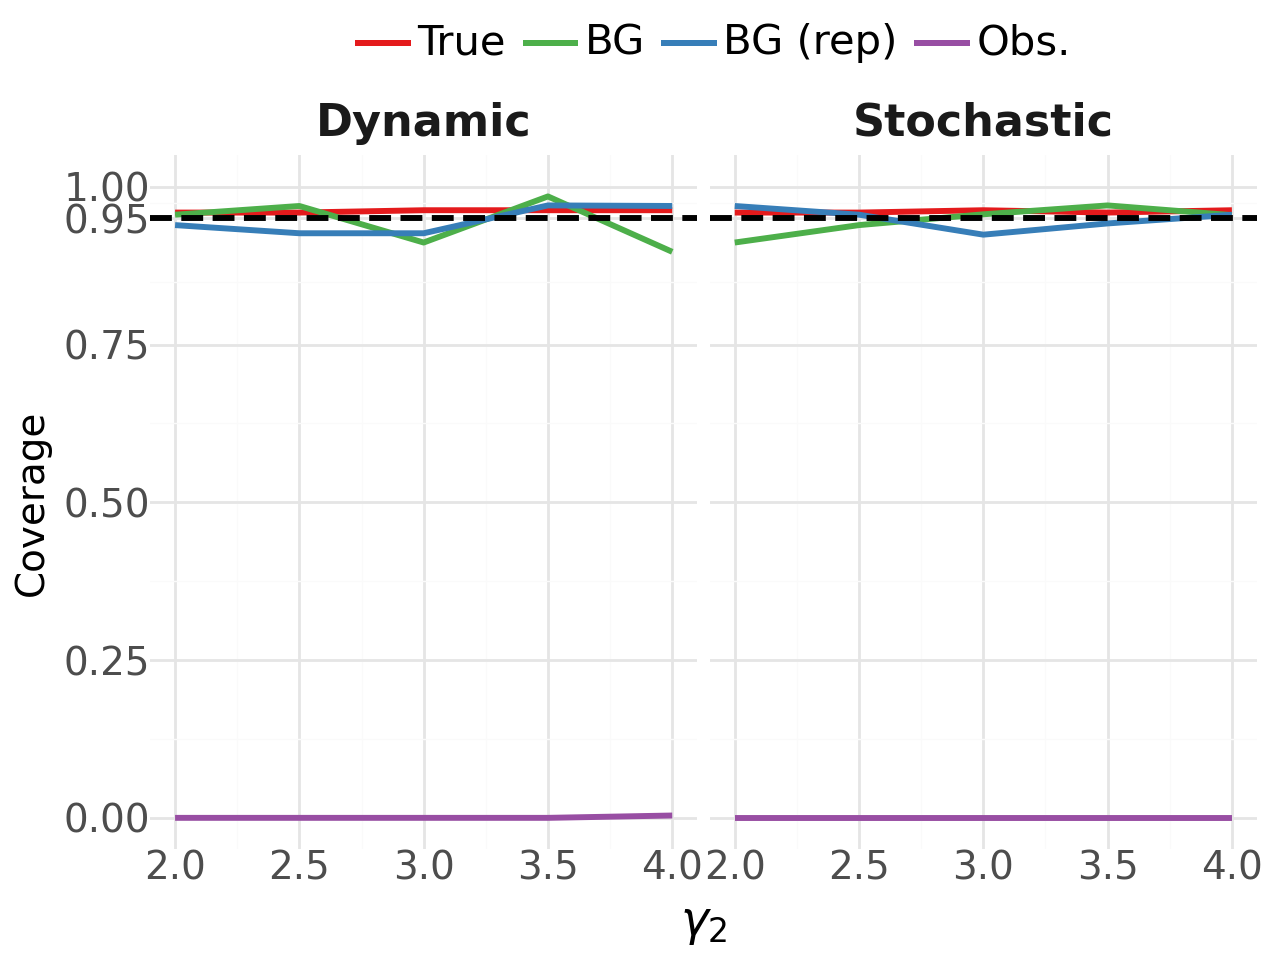

c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\ggplot.py:616: PlotnineWarning: Filename: Simulations/results/figs/plot_coverage.png


In [12]:
# Coverage plot

plot_coverage = (
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="coverage", 
                                 group="model", 
                                 color="model",
                                 ))
    + p9.geom_line(size=1.2)
    + p9.geom_hline(yintercept=0.95, linetype="dashed", color="black", size=1.2)
    + p9.scale_y_continuous(limits=(0, 1), breaks=[0.0,0.25,0.5, 0.75, 0.95, 1])
    + p9.theme_minimal()
    + p9.facet_wrap("estimand", scales="fixed")

    + p9.labs(y="Coverage", x=r'$\gamma_2$', color="", shape="")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_color_manual(values=custom_palette)

    + p9.theme(
        legend_text=p9.element_text(size=15),
        legend_key_size=20,
        axis_title_x=p9.element_text(size=17,),
        axis_title_y=p9.element_text(size=14,),
        axis_text_x=p9.element_text(size=14),
        axis_text_y=p9.element_text(size=14),
        strip_text=p9.element_text(size=16, weight='bold'),  
        legend_position="top",
    )
)

plot_coverage.show()

plot_coverage.save("Simulations/results/figs/plot_coverage.png", dpi=300)
    